In [31]:
import os
from lxml import etree

import numpy as np
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

In [27]:
PERSEUS_DATA_HOME = os.path.join("data", "LemmatizedAncientGreekXML-master")
TEXT_DATA_HOME = os.path.join(PERSEUS_DATA_HOME, "texts")

# Learning Embeddings

We'll use Gensim's [implementation of word2vec](https://radimrehurek.com/gensim/models/word2vec.html). It expects a list of sentences (a lists of lists of tokens) for training data, but instead of loading the entire training corpus into a list in memory, we can pass Gensim a stream that one-by-one loads and discards the sentences from memory as needed for training. 

The `MyCorpus` class below implements a stream of lemmatized sentences (lists of lemmatized tokens) extracted word-by-word from the [Perseus XML](https://github.com/gcelano/LemmatizedAncientGreekXML) corpus of Greek texts.

In [48]:
class MyCorpus:
    def __init__(self, corpus_filenames):
        self.corpus_filenames = corpus_filenames
    def __iter__(self):
        for filename in self.corpus_filenames:
            filepath = os.path.join(TEXT_DATA_HOME, filename)
            tree = etree.parse(filepath)
            root = tree.getroot()
            for sentence in root.iter('s'):
                sentence_lemmas = []
                for word in sentence.iter('l1', 'l2'):
                    sentence_lemmas.append(word.text)
                yield sentence_lemmas

# Choose a training corpus
We can train embeddings on any selection of texts. The more text we have for training, the better our embeddings will be, as long as the texts are relevant to our research purposes. Here we'll just use the whole corpus of texts, but we could also choose meaningful subsets of texts such as:
 - Plato's texts
 - Philosophical texts from the Classical period
 - Prose texts
 - Texts from the 2nd and 3rd centuries AD
The only requirement is that the subset not be too small to furnish enough training text for the embedding algorithm. What counts as "enough" will depend on what the embeddings are being used for, as well as on the model parameters (even smaller corpora can furnish useful vectors  with fewer dimensions can learn useful representations 

In [17]:
corpus_filenames = os.listdir(TEXT_DATA_HOME)

In [18]:
# initialize the corpus object
corpus = MyCorpus(corpus_filenames)
corpus.corpus_filenames[:10]

['tlg0062.tlg045.1st1K-grc1.xml',
 'tlg0062.tlg050.1st1K-grc1.xml',
 'tlg4102.tlg019.opp-grc1.xml',
 'tlg0010.tlg024.perseus-grc2.xml',
 'tlg0540.tlg030.perseus-grc2.xml',
 'tlg0011.tlg008.perseus-grc2.xml',
 'tlg0031.tlg014.perseus-grc2.xml',
 'tlg0530.tlg012.1st1K-grc1.xml',
 'tlg0008.tlg001.perseus-grc3.xml',
 'tlg0627.tlg021.1st1K-grc1.xml']

In [19]:
# train embeddings
model = Word2Vec(sentences=corpus, window=10, vector_size=200, min_count=5)

Once we have embeddings that are working well, we can save them to disk and load them when we want to use them again, rather than retraining them from scratch each time.

In [47]:
# save the embeddings
model.save("all_cbow_win10_dim200_min5")

# Loading Saved Embeddings 

In [20]:
def load_model_vectors(model_fname):
    model = Word2Vec.load(model_fname)
    return model.wv

# Exploring the Embeddings with t-SNE

In [52]:
def prepare_topn_clusters(term_list, vectors, topn):
    embedding_clusters = []
    word_clusters = []
    for word in term_list:
        embeddings = []
        words = []
        for similar_word, _ in vectors.most_similar(word, topn=topn):
            words.append(similar_word)
            embeddings.append(vectors[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return (embeddings_2d, word_clusters)


# TODO improve function signature
def tsne_plot_similar_words(title, term_list, vectors, topn=25, a=0.7, filename=None):
    embedding_clusters, word_clusters = prepare_topn_clusters(term_list, vectors, topn) 
    plt.figure(figsize=(20, 15))
    colors = cm.rainbow(np.linspace(0, 1, len(term_list)))
    for label, embeddings, words, color in zip(term_list, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [22]:
target_words = [
    'τύραννος', 
    'λόγος',
    'ἱερός', 
    'φίλος', 
    'δυσμενής', 
    'πλούσιος', 
]

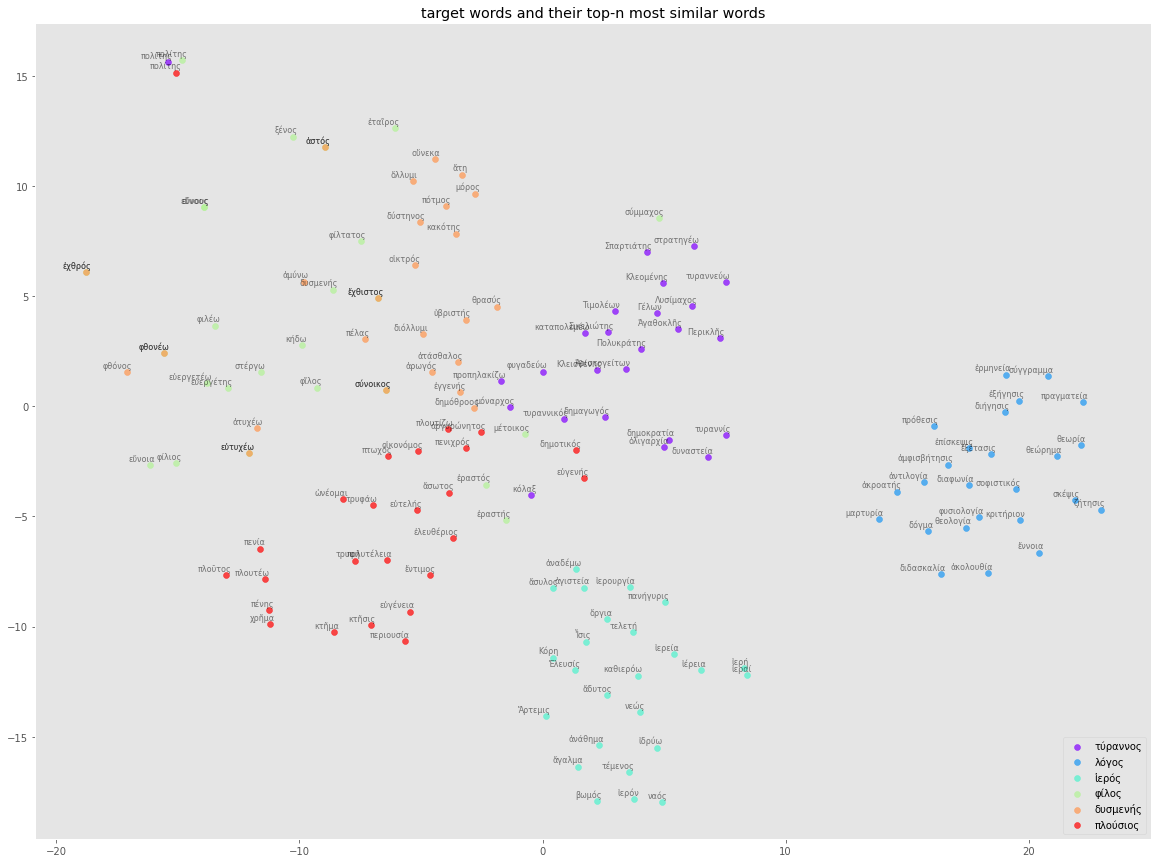

In [51]:
tsne_plot_similar_words("target words and their top-n most similar words", term_list=target_words, vectors=model.wv)

In [50]:
central_GK_vocab = [
    'τύραννος', 
    'λόγος',
    'ἱερός', 
    'φίλος', 
    'δυσμενής', 
    'πλούσιος', 
    'πατρῷος', 
    'Λυδός', 
    'Θηβαῖος', 
    'Θρασύβουλος', 
    'ὄρχησις', 
    'ἀείδω',
    'ῥῆμα',
    'ψεῦδος',
    'ἔρως',
    'ἀγαπάω',
    'μήτηρ',
    'πατήρ',
    'ὅσιος',
    'θῆλυς',
    'ἄρσην',
    'βοῦς',
    'ἔρανος',
    'ἀμοιβή',
    'σκυτοτόμος',
    'δίκαιος',
    'μίασμα',
    'μισθός',
    'πεινάω',
    'ἱκέτης',
    'ἀφροσύνη',
    'τέρψις',
    'πρόφρων',
    'σπουδαῖος',
    'ἀνδρεῖος',
    'σώφρων',
    'ἄφρων',
    'ἐπιστήμη',
    'δόξα',
    'σκότος',
    'φάος',
    'ζόφος',
    'λαιός',
    'δεξιτερός',
    'δεξιός',
    'εὐμενής',
    'ἀριστερός',
    'εὐώνυμος',
    'εὐφημέω',
    'κῶμος',
    'τίθημι',
    'λαμβάνω',
    'διατάσσω',
    'σιωπάω',
    'τολμάω',
    'φιλέω',
    'ἡδύς',
    'χρηστός',
    'ψυχή',
    'σῶμα',
    'οὐράνιος',
    'ἀθανασία',
    'θνητός',
    'χθόνιος',
    'ἄιστος',
    'μέλπω',
    'θαλία',
    'κεραμεύς',
    'πόνος',
    'ἀγοράζω',
    'κάπηλος',
    'ἔπαινος',
    'ἀθλέω',
    'στεφανίτης',
    'ἀγώνισμα',
    'ἀποδημέω',
    'χώρα',
    'ἐσχατιά',
    'περίοικος',
    'κατήκους',
    'αὐτονομία',
    'μηδίζω',
]